In [1]:
import pandas as pd
import datetime
import json
import numpy as np
import string
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import TensorDataset

import torchtext
from torchtext.vocab import Vectors
from torchtext import data, datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# データのロード

In [2]:
for i, date in enumerate(range(2011, 2019)):
    tmp = pd.read_csv('./data/news/' + str(date) + '.csv', encoding='cp932')
    tmp = tmp[tmp['Company_IDs(TSE)'] == '7203']
    tmp = tmp[['Time_Stamp_Original(JST)', 
                        'Company_Code(TSE)', 
                        'Headline', 
                        'News_Source',
                        'Company_Relevance', 
                        'Keyword_Article']]

    # 欠損除去
    tmp = tmp[~tmp["Keyword_Article"].isnull()]

    # タグ除去
    tmp = tmp[(tmp['News_Source'] == '日経') | 
                        (tmp['News_Source'] == 'ＮＱＮ') |
                        (tmp['News_Source'] == 'ＱＵＩＣＫ') | 
                        (tmp['News_Source'] == 'Ｒ＆Ｉ')]

    tmp.index = pd.to_datetime(tmp["Time_Stamp_Original(JST)"])
    tmp = tmp.drop("Time_Stamp_Original(JST)", axis=1)
    
    if i == 0:
        df1 = tmp.copy()
    else:
        df1 = pd.concat([df1, tmp])

# インデックスを設定

In [3]:
def norm_time(x):
    if x.hour > 15:
        return x + datetime.timedelta(days=1)
    return x

time = pd.to_datetime(df1.index.values)
df1.index = df1.index.map(norm_time)
df1.index = df1.index.date

# 株価を挿入する

In [4]:
# 株価を取り出す
df2 = pd.read_csv('./data/stock_price/7203.csv', index_col=0)
df2.index = pd.to_datetime(df2['date'])
df2.index = df2.index.date
df2 = df2.drop(['date'], axis=1)
df2.head(10)

,adj_close
2011-01-04,3265.0
2011-01-05,3295.0
2011-01-06,3380.0
2011-01-07,3455.0
2011-01-11,3455.0
2011-01-12,3500.0
2011-01-13,3535.0
2011-01-14,3550.0
2011-01-17,3500.0
2011-01-18,3510.0


# 時系列をくっつける

In [5]:
df3 = pd.concat([df1,df2], axis=1, join_axes=[df1.index])
df3['price'] = np.round(df2.pct_change().shift(-1) * 100, 10)
df3['Keyword_Article'] = \
    df3.groupby(level=0).apply(lambda x: ':<pad>:'.join(list(x['Keyword_Article'])))
df3 = df3.dropna()

df3 = df3[~df3.duplicated(subset=['Keyword_Article'])]

/home/ts-zemi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  """Entry point for launching an IPython kernel.


In [6]:
df3.head()

,Company_Code(TSE),Headline,News_Source,Company_Relevance,Keyword_Article,adj_close,price
2011-01-04,7203.0,<日経>◇次世代車の研究開発 名大に国内最大拠点,日経,38,安全:環境:負荷:開発:目指す:開所式:研究拠点:効率:簡素化:次世代:電気自動車:電気:幅...,3265.0,0.918836
2011-01-05,7203.0,<日経>◇12月の中国新車販売、トヨタが単月で過去最高,日経,100,北京:中国:１２月:新車販売台数:前年同月比:増:過去最高:制限:受け:全国:各地:乗用車:...,3295.0,2.579666
2011-01-06,7203.0,<NQN>◇トヨタ社長「今年は後半に晴れ間」 為替は１ドル＝90円を期待,ＮＱＮ,100,豊田:見通し:販売:エコカー補助金:安定的:伸び:株価:為替:水準:日経平均株価:最低:ライ...,3380.0,2.218935
2011-01-07,7203.0,<日経>◇福岡県、自動車の技術者育成へ新組織 年内、中小向け,日経,37,自動車産業:強化:福岡:先端:設置:方針:技術:調査:ニーズ:カリキュラム:大学:受け:生産...,3455.0,0.000000
2011-01-11,7203.0,<日経>◇トヨタ、米ミシガン州に安全研究センター新設,日経,100,先進:安全:子供:高齢者:事故:向上:目指す:米国:大規模:リコール:回収:問題:開催:豊田...,3455.0,1.302460


# csvファイルに保存する

In [7]:
train_date = 2015
test_date = 2016

In [8]:
df4 = pd.concat([df3[['Keyword_Article', 'price']].rename(
                                      columns={'Keyword_Article': 'state', 'price': 'reward'}),
                               df3[['Keyword_Article']].shift(-1).rename(
                                      columns={'Keyword_Article': 'next_state'})], axis=1).dropna()
df4 = df4[['state', 'next_state', 'reward']]

date_year = df4.index.map(lambda x: x.year)

In [9]:
df4[date_year <= train_date].to_csv(
        './data/news/text_train.tsv',
        header=None,
        index=None,
        sep='\t')

In [10]:
df4[(train_date < date_year) & (date_year < test_date)].to_csv(
        './data/news/text_val.tsv',
        header=None,
        index=None,
        sep='\t')

In [11]:
df4[test_date <= date_year].to_csv(
        './data/news/text_test.tsv',
        header=None,
        index=None,
        sep='\t')

# Dataの作成

In [12]:
# 前処理
def preprocessing_text(text):
    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ",") or (p == ":") or (p == "<")or (p == ">"):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    text = re.sub(r'[0-9 ０-９]', '0', text)
    
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）
def tokenizer_punctuation(text):
    return text.strip().split(':')

# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret

In [13]:
max_length = 256
batch_size = 32

# 読み込んだ内容に対して行う処理を定義
TEXT = torchtext.data.Field(sequential=True, tokenize=tokenizer_with_preprocessing, 
                            use_vocab=True,
                            lower=True, include_lengths=True, batch_first=True, fix_length=max_length, 
                            init_token="<cls>", eos_token="<eos>")
LABEL = torchtext.data.Field(sequential=False, use_vocab=False, dtype=torch.float)

In [14]:
train_ds = torchtext.data.TabularDataset.splits(
    path='./data/news', train='text_train.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
train_ds = train_ds[0]

test_ds = torchtext.data.TabularDataset.splits(
    path='./data/news', train='text_test.tsv',
    format='tsv',
    fields=[('Text1', TEXT), ('Text2', TEXT), ('Label', LABEL)])
test_ds = test_ds[0]

# japanese_fasttext_vectors = Vectors(name='./data/news/cc.ja.300.vec')
TEXT.build_vocab(train_ds, 
#                  vectors=japanese_fasttext_vectors,
                 min_freq=10)
TEXT.vocab.freqs

train_dl = torchtext.data.Iterator(
    train_ds, batch_size=batch_size, train=True)
test_dl = torchtext.data.Iterator(
    test_ds, batch_size=100, train=True, shuffle=False)

In [15]:
batch = next(iter(train_dl))
print(batch.Text1)
print(batch.Text2)
print(batch.Label)

(tensor([[   2,    4,    4,  ...,    1,    1,    1],
        [   2,    4,    1,  ...,    1,    1,    1],
        [   2,    4,  393,  ...,    1,    1,    1],
        ...,
        [   2,  343,    0,  ...,    1,    1,    1],
        [   2,  105,   76,  ...,    1,    1,    1],
        [   2,  105, 1029,  ...,    1,    1,    1]]), tensor([ 81,  34, 191,  91,  35, 146,  10,  99,  66, 256, 117,  96, 256,  74,
        136,  86, 126, 154,  44,  23,  66,  68, 155,  97,  17, 196,  62,  25,
         76, 104,  12,  21]))
(tensor([[   2,  383,  367,  ...,    0,    0,    3],
        [   2,    4,  115,  ...,    1,    1,    1],
        [   2,  117,  218,  ...,    1,    1,    1],
        ...,
        [   2,   35,   55,  ...,    1,    1,    1],
        [   2,  128, 1054,  ...,    1,    1,    1],
        [   2,  894,   28,  ...,    1,    1,    1]]), tensor([256, 228,  37, 223,  32,  32,  74, 256,  12, 256,  67,  11,  72,  86,
        244, 241,  16,  92,  13,  62,  17, 225,  35,  21, 116, 126,  14,  27,
  

# モデル構築

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
batch.Text1[0].shape

torch.Size([32, 256])

In [18]:
class IQN(nn.Module):
    def __init__(self, text_embedding_vector, vocab_size, embedding_dim,
                 n_filters, filter_sizes, pad_idx,
                 d_model=300, n_actions=1, n_quant=8):
        super().__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.n_actions = n_actions
        self.n_quant = n_quant
        
        self.embedding = nn.Embedding(
            vocab_size, 
            embedding_dim, 
            padding_idx=pad_idx)


        self.phi = nn.Linear(64, 64)
        # self.phi_bias = nn.Parameter(torch.zeros(64))

        # self.fc0 = nn.Linear(n_state, 64)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1,
                      out_channels=n_filters,
                      kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        self.fc0 = nn.Linear(len(filter_sizes) * n_filters, 64)

        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_q = nn.Linear(64, n_actions)

    def forward(self, text, eta=1.0):
        # [batch_size, num_state]
        mb_size = text.size(0)

        # [batch_size, sen_len] → [batch_size, sen_len, emb_dim]
        embedded = self.embedding(text)
        
        # [batch size, 1, sen len, emb dim]
        embedded = embedded.unsqueeze(1)

        # [batch size, n_filters, sen len - filter_sizes[n] + 1]
        x = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        # [batch size, n_filters, sen len - filter_sizes[n] + 1]
        x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in x]

        # [batch size, n_filters * len(filter_sizes)]
        x = torch.cat(x, dim=1)

        # [batch size, 64]
        x = F.relu(self.fc0(x))

        # [batch_size, 64] 
        # → [batch_size, quant, 64]
        x = x.repeat(1, 1, self.n_quant).view(mb_size, self.n_quant, 64)

        # [batch_size, quant, 1]
        tau = eta * torch.rand(mb_size, self.n_quant).to(self.device).view(mb_size, -1, 1)

        # [1, 64]
        pi_mtx = math.pi * torch.arange(0, 64, 1.0).to(self.device).unsqueeze(0)

        # [batch_size, quant, 64]
        cos_tau = torch.cos(torch.matmul(tau, pi_mtx))

        # [batch_size, quant, quantile_embedding_di64]
        phi = F.relu(self.phi(cos_tau))

        # [batch_size, quant, 4]
        h = x * phi

        # [batch_size, quant, 64]
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))

        # [batch_size, quant, 2]
        action_value = self.fc_q(h).view(mb_size, self.n_quant, self.n_actions)
        # action_value = action_value.transpose(0, 2, 1)

        return action_value, tau

In [19]:
def huber(x):
        cond = (x.abs() < 1.0).float().detach()
        return 0.5 * x.pow(2) * cond + (x.abs() - 0.5) * (1.0 - cond)

In [20]:
VOCAB_SIZE = len(TEXT.vocab.freqs)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
PAD_IDX = 1
N_QUANT = 51
GAMMA = 0.99

In [21]:
model = IQN(TEXT.vocab.vectors, VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS,
                        FILTER_SIZES, PAD_IDX, n_quant=N_QUANT)

target_model = IQN(TEXT.vocab.vectors, VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS,
                        FILTER_SIZES, PAD_IDX, n_quant=N_QUANT)

model = model.to(device)
target_model = target_model.to(device)

target_model.load_state_dict(model.state_dict())

<All keys matched successfully>

# 最適化

In [22]:
# 最適化手法
learning_rate = 2.5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
def accuracy(scores, y):    
    correct = (scores == y)
    acc = correct.sum() / len(correct)
    return acc

def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()
    return acc

def huber(x):
        cond = (x.abs() < 1.0).float().detach()
        return 0.5 * x.pow(2) * cond + (x.abs() - 0.5) * (1.0 - cond)

In [24]:
## テスト
batch = next(iter(train_dl))

In [25]:
num_epochs = 30
TARGET_UPDATE_FREQ = 10
# dataloaders_dict = {'train': train_dl, 'val':val_dl}
dataloaders_dict = {'train': train_dl}

print('----start----')

torch.backends.cudnn.benchmark = True

for epoch in range(num_epochs):
    epi_rewards = []
    neutrals = []
    buys = []
    
    # update target_model
    if epoch % TARGET_UPDATE_FREQ == 0:
        target_model.load_state_dict(model.state_dict())
    
    for batch in (dataloaders_dict['train']):      
        # curr_q
        states = batch.Text1[0].to(device)
        next_states = batch.Text2[0].to(device)
        rewards = batch.Label.to(device)
    
        curr_q, tau = model(states)
        action_value = curr_q.mean(dim=1)
        action_value[action_value > 0] = 1
        action_value[action_value <= 0] = 0
        selected_actions = action_value.cpu().detach().numpy().reshape(-1)
        
        epi_rewards.append((
            selected_actions * rewards.detach().cpu().numpy()).sum())
        

        # target_q
        with torch.no_grad():
            next_q, _ = target_model(next_states)
            next_q = next_q.squeeze(2)

            target_q = rewards.reshape(-1, 1) + GAMMA * next_q
            target_q = target_q.unsqueeze(2)
            target_q = target_q.repeat(1, 1, N_QUANT)
            target_q = target_q.permute(0, 2, 1)

        # (BATCH, N_QUANT, N_QUANT)
        tau = tau.repeat(1, 1, N_QUANT)
        diff = target_q - curr_q

        loss = huber(diff)

        I_delta = (diff<0).double()
        loss *= torch.abs(tau - I_delta)

        # huber loss
        loss = torch.mean(torch.sum(torch.mean(loss, dim=2), dim=1))

        # backprop loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('--------------------')
    print('epoch:', epoch)
    print('loss:', loss.item())
    print('epi_reward:', sum(epi_rewards))
    print('neutrals:', sum(neutrals), '  buys:', sum(buys))

----start----
--------------------
epoch: 0
loss: 21.416719436645508
epi_reward: 25.037289142608643
neutrals: 0   buys: 0
--------------------
epoch: 1
loss: 15.505341529846191
epi_reward: 73.59831666946411
neutrals: 0   buys: 0
--------------------
epoch: 2
loss: 14.469315528869629
epi_reward: 106.56386911869049
neutrals: 0   buys: 0
--------------------
epoch: 3
loss: 12.569989204406738
epi_reward: 229.41797602176666
neutrals: 0   buys: 0
--------------------
epoch: 4
loss: 17.90811538696289
epi_reward: 370.88405585289
neutrals: 0   buys: 0
--------------------
epoch: 5
loss: 7.712935924530029
epi_reward: 547.0018062591553
neutrals: 0   buys: 0
--------------------
epoch: 6
loss: 5.656209945678711
epi_reward: 639.7702236175537
neutrals: 0   buys: 0
--------------------
epoch: 7
loss: 1.8101930618286133
epi_reward: 657.9494018554688
neutrals: 0   buys: 0
--------------------
epoch: 8
loss: 1.4922621250152588
epi_reward: 657.1436920166016
neutrals: 0   buys: 0
--------------------
epoc

# 描画

In [26]:
batch = next(iter(train_dl))
states = batch.Text1[0].to(device)
next_states = batch.Text2[0].to(device)
rewards = batch.Label.to(device)

In [27]:
batch = next(iter(test_dl))
print(batch.Text1[0].shape)

torch.Size([100, 256])


i =  0 実際:  -1.9789648 平均:  0.532 SR:  0.627
CVaR 平均:  -0.636 CVaR SR:  -0.815
i =  1 実際:  -2.6118877 平均:  0.681 SR:  0.563
CVaR 平均:  -0.563 CVaR SR:  -0.488
i =  2 実際:  -0.4928965 平均:  -0.067 SR:  -0.112
CVaR 平均:  -1.063 CVaR SR:  -1.416
i =  3 実際:  -1.5879953 平均:  1.526 SR:  1.109
CVaR 平均:  0.405 CVaR SR:  0.513
i =  4 実際:  2.931162 平均:  0.09 SR:  0.113
CVaR 平均:  -0.952 CVaR SR:  -1.299
i =  5 実際:  -2.243636 平均:  0.573 SR:  0.442
CVaR 平均:  -0.439 CVaR SR:  -0.633
i =  6 実際:  -0.2515165 平均:  0.798 SR:  0.623
CVaR 平均:  -0.554 CVaR SR:  -0.484
i =  7 実際:  0.9196084 平均:  -0.207 SR:  -0.215
CVaR 平均:  -1.754 CVaR SR:  -1.705
i =  8 実際:  -3.3803644 平均:  0.234 SR:  0.388
CVaR 平均:  -1.078 CVaR SR:  -1.039
i =  9 実際:  6.727159 平均:  -1.071 SR:  -0.906
CVaR 平均:  -2.383 CVaR SR:  -2.499


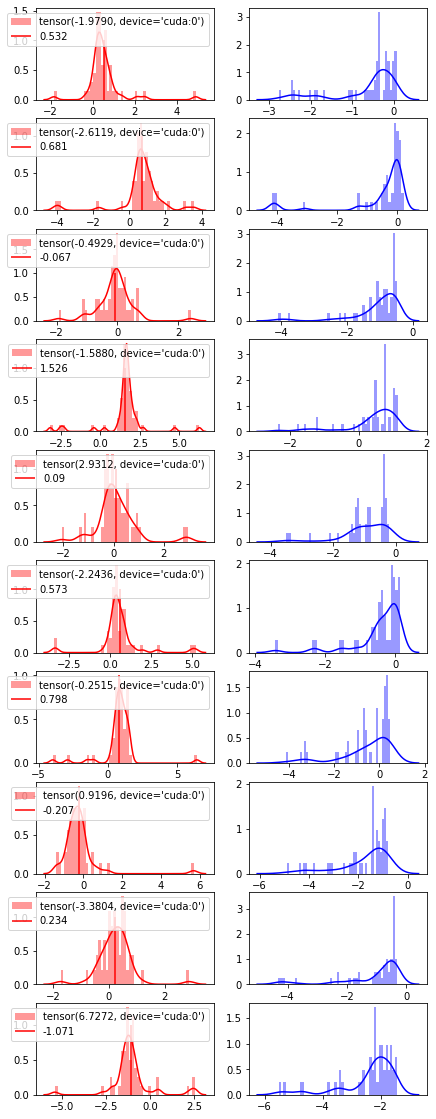

In [39]:
start = 0
N = 10
win = 0
fig, ax = plt.subplots((N-start), 2, figsize=(7, (N-start)*2));
for i in range(start, N):
    states = batch.Text1[0].to(device)
    rewards = batch.Label.to(device)
    curr_q, _ = model(states[i].unsqueeze(0), eta=1)
    dist_hist = curr_q.view(-1).cpu().detach().numpy()
    sns.distplot(dist_hist, bins=51, color='red', ax=ax[i - start][0], label=str(rewards[i]))
    
    cvar, _ = model(states[i].unsqueeze(0), eta=0.1)
    cvar_dist = cvar.view(-1).cpu().detach().numpy()
    sns.distplot(cvar_dist, bins=51, color='blue', ax=ax[i - start][1], label=str(rewards[i]))
    
    # 期待値
    ax[i - start][0].vlines(
        np.round(dist_hist.mean(), 3), 
        ymin=0, ymax=1, color='red', label=str(mean))

    print('i = ', i,
              '実際: ', rewards[i].cpu().detach().numpy(),
              '平均: ', mean,
              'SR: ', np.round(dist_hist.mean() / dist_hist.std(), 3))

    print('CVaR 平均: ', np.round(cvar_dist.mean(), 3),
              'CVaR SR: ', np.round(cvar_dist.mean() / cvar_dist.std(), 3))

    ax[i-start][0].legend()

In [41]:
win / (N-start)

0.0